## PREPARATION OF DATA

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path):  
    return glob.glob(path)    # Finds all the pathnames matching a specified pattern
print(findFiles('/content/data/names/*.txt'))

['/content/data/names/Dutch.txt', '/content/data/names/Vietnamese.txt', '/content/data/names/Scottish.txt', '/content/data/names/German.txt', '/content/data/names/Korean.txt', '/content/data/names/Arabic.txt', '/content/data/names/Chinese.txt', '/content/data/names/English.txt', '/content/data/names/French.txt', '/content/data/names/Portuguese.txt', '/content/data/names/Polish.txt', '/content/data/names/Spanish.txt', '/content/data/names/Greek.txt', '/content/data/names/Italian.txt', '/content/data/names/Czech.txt', '/content/data/names/Irish.txt', '/content/data/names/Japanese.txt', '/content/data/names/Russian.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + '.,;'
n_letters = len(all_letters)

# Converting Unicode to ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [3]:
category_lines = {}   # Language -> lines in text file
all_categories = []   # List of languages

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/data/names/*.txt'):
    category = os.path. splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
print(category_lines['Greek'][:5])

['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']


## Turning names into Pytorch Tensors

In [5]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)  # One-hot vectors is of shape <1, vocab_size>
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)   # <name_size, 1, vocab_size>
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('F'))
print(lineToTensor('test'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

## CREATING THE NETWORK

<img src = 'https://i.imgur.com/Z2xbySO.png' />

In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7968, -2.8661, -2.8725, -2.9136, -2.9138, -2.9043, -2.9736, -2.9343,
         -2.9295, -2.7891, -2.9781, -2.9574, -2.8061, -2.8181, -2.9509, -2.8593,
         -2.9104, -2.8835]], grad_fn=<LogSoftmaxBackward0>)


## Preparing for Training

In [8]:
# Get the index of the greatest value
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
print(categoryFromOutput(output))

('Portuguese', 9)


In [9]:
# Getting a random training example
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])

    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)

    return category, line, category_tensor, line_tensor

for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f'Category = {category}  /  line = {line}')

Category = Spanish  /  line = Holguin
Category = German  /  line = Adam
Category = Korean  /  line = Gwang
Category = Portuguese  /  line = Franco
Category = Japanese  /  line = Mitsukuri


In [10]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

    return output, loss.item()

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s // 60
    return '%dm %ds' % (m, s - m*60)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss =  train(category_tensor, line_tensor)

    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 12s) 2.5432 Wood / Scottish ✓
10000 10% (0m 21s) 1.1184 Ron / Korean ✓
15000 15% (0m 28s) 1.5500 Song / Chinese ✗ (Korean)
20000 20% (0m 35s) 3.0144 Aitken / Russian ✗ (Scottish)
25000 25% (0m 43s) 1.1606 Jevanov / Russian ✓
30000 30% (0m 50s) 2.5489 Pasfield / French ✗ (English)
35000 35% (0m 57s) 1.6590 Tomanek / Czech ✓
40000 40% (1m 4s) 1.2274 Alamilla / Spanish ✓
45000 45% (1m 12s) 2.3647 Tuma / Japanese ✗ (Arabic)
50000 50% (1m 19s) 0.3835 Gibson / Scottish ✓
55000 55% (1m 27s) 2.4782 Charge / Irish ✗ (English)
60000 60% (1m 35s) 1.7548 Bock / Vietnamese ✗ (Czech)
65000 65% (1m 42s) 0.6848 Cao / Vietnamese ✓
70000 70% (1m 50s) 0.3288 Quraishi / Arabic ✓
75000 75% (1m 57s) 1.9573 Simon / English ✗ (Dutch)
80000 80% (2m 4s) 0.4655 Luu / Vietnamese ✓
85000 85% (2m 12s) 1.9384 Dominguez / German ✗ (Spanish)
90000 90% (2m 19s) 2.0521 Eatros / Portuguese ✗ (Greek)
95000 95% (2m 26s) 0.0314 Filipowski / Polish ✓
100000 100% (2m 34s) 1.4996 Dominguez / German ✗ (Spanish)


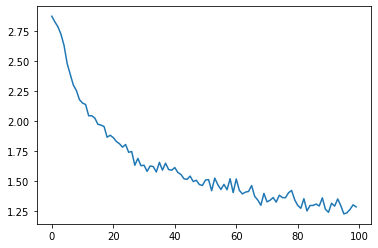

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating Results

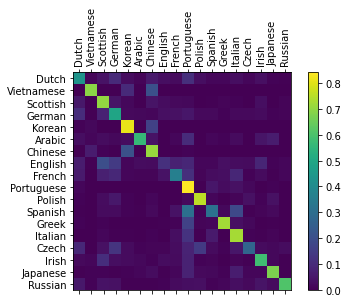

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Testing on User Input

In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.77) Russian
(-0.95) Czech
(-2.79) Polish

> Jackson
(-0.27) Scottish
(-2.32) English
(-3.20) Dutch

> Satoshi
(-0.72) Arabic
(-1.73) Italian
(-2.31) Polish
